## Data Processing

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
import json
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import spacy
import Utility as util
from Utility import REDataset_entities, REModelWithAttention
#nlp = spacy.load("en_core_web_sm")

In [2]:
df_nyt = pd.read_csv('data/nyt.csv')

In [4]:
df_aug_llama = pd.read_csv('data/nyt_less100_rule_upd.csv')

In [5]:
print(f'orignal dataset = {len(df_nyt)} and augumented data = {len(df_aug_llama)}')

orignal dataset = 56196 and augumented data = 550


In [6]:
df_combined = pd.concat([df_nyt, df_aug_llama], ignore_index=True) # combined augumented data with orignal FewRel training data
print(len(df_combined))

56746


In [4]:
train_df, test_df = train_test_split(df_nyt, test_size=0.2, random_state=42) # To take test set from orignal data
print(f'Train set = {len(train_df)} and test set = {len(test_df)}')

Train set = 44947 and test set = 11237


In [3]:
very_low = ['ethnicity', 'industry', 'profession']
#values_to_remove = ['value1', 'value2', 'value3']
df_nyt = df_nyt[~df_nyt['relation'].isin(very_low)]

In [5]:
label_encoder = LabelEncoder()
train_df['relation_id'] = label_encoder.fit_transform(train_df['relation'])
test_df['relation_id'] = label_encoder.fit_transform(test_df['relation'])

In [6]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")  # Choose the same model as in your model
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [7]:
max_seq_length = 128  
train_dataset = util.REDataset_entities(train_df,tokenizer, max_seq_length)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = util.REDataset_entities(test_df, tokenizer, max_seq_length)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [8]:
model = REModelWithAttention(tokenizer, num_classes=len(label_encoder.classes_)).to(device)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

In [ ]:
train_loss, valid_loss = util.train(model, train_loader, test_loader, criterion, optimizer, device, patience=3, num_epochs=20) # ruels less 100 augumentation

Epoch [1/20] - Training Loss: 0.7988- Validation Loss: 0.4904
Epoch [2/20] - Training Loss: 0.4761- Validation Loss: 0.3623
Epoch [3/20] - Training Loss: 0.3767- Validation Loss: 0.2899
Epoch [4/20] - Training Loss: 0.3175- Validation Loss: 0.2466


In [14]:
print(f'train loss = {train_loss} \n\nValidation loss = {valid_loss}')

train loss = [0.7988297150479766, 0.47605005620633334, 0.37674460995610565, 0.31745207461338437, 0.2678861872071512, 0.22915109922309335, 0.19719209528413706, 0.1651868660540006, 0.14052459211146465, 0.11617909743194127, 0.09939778716807525, 0.08279133582412367, 0.06788468849021662, 0.05749539508184866, 0.04773481466984673, 0.04500142892593205, 0.039436235447847204, 0.037853868764867425, 0.03615823756279531, 0.03299982596120273] 

Validation loss = [0.4903603371180279, 0.36229428462159463, 0.2899073418177349, 0.24657177448692455, 0.20775129275107887, 0.1711260638816256, 0.13708275941161202, 0.11505797019123401, 0.08201328241069553, 0.07735673864404867, 0.05060546557733815, 0.04553923356432048, 0.02907773083023412, 0.031767119641963416, 0.02138860534235481, 0.01995355852176173, 0.01641687681221298, 0.018824403697475595, 0.016480722953073523, 0.014922377423540701]


In [17]:
evaluate_model(model, test_loader,device) #  ruels less 100 augumentation

Accuracy: 0.9936
Precision: 0.9876
Recall: 0.9818
F1 Score: 0.9839


In [12]:
train_loss, valid_loss = util.train(model, train_loader, test_loader, criterion, optimizer, device, patience=3, num_epochs=20) # falcon less 100 augumentation

Epoch [1/20] - Training Loss: 0.8249- Validation Loss: 0.4957
Epoch [2/20] - Training Loss: 0.4848- Validation Loss: 0.3609
Epoch [3/20] - Training Loss: 0.3798- Validation Loss: 0.2882
Epoch [4/20] - Training Loss: 0.3169- Validation Loss: 0.2530
Epoch [5/20] - Training Loss: 0.2687- Validation Loss: 0.2083
Epoch [6/20] - Training Loss: 0.2311- Validation Loss: 0.1680
Epoch [7/20] - Training Loss: 0.1973- Validation Loss: 0.1376
Epoch [8/20] - Training Loss: 0.1686- Validation Loss: 0.1065
Epoch [9/20] - Training Loss: 0.1384- Validation Loss: 0.0884
Epoch [10/20] - Training Loss: 0.1158- Validation Loss: 0.0710
Epoch [11/20] - Training Loss: 0.0968- Validation Loss: 0.0430
Epoch [12/20] - Training Loss: 0.0780- Validation Loss: 0.0356
Epoch [13/20] - Training Loss: 0.0667- Validation Loss: 0.0349
Epoch [14/20] - Training Loss: 0.0591- Validation Loss: 0.0245
Epoch [15/20] - Training Loss: 0.0474- Validation Loss: 0.0199
Epoch [16/20] - Training Loss: 0.0461- Validation Loss: 0.0199
E

In [13]:
print(f'train loss = {train_loss} \n\nValidation loss = {valid_loss}')

train loss = [0.8249171136195669, 0.4847737664470188, 0.37978945469295494, 0.3168560386989484, 0.2687014033482319, 0.23109543897182433, 0.19732036534228817, 0.16861437664287698, 0.1384316839884586, 0.11581156487625544, 0.09679737806470731, 0.0779937398330699, 0.06667350690855682, 0.059128056130733256, 0.047448888092482745, 0.04606924708954088, 0.04457873830665436, 0.03898031978564007, 0.0370475461477296, 0.035847557040126675] 

Validation loss = [0.4957036527916582, 0.3609222361926913, 0.2882450213811482, 0.25295872739347575, 0.20832832465285545, 0.16804323543620642, 0.13755728986988514, 0.10645073395521408, 0.08837592985687263, 0.07103401094129955, 0.04304587830113919, 0.03561087635467036, 0.03486022924061367, 0.02454112168370025, 0.01992860127274144, 0.01991622557762743, 0.021064441872181497, 0.016610306540107183, 0.025066341120914444, 0.016484793587711]


In [16]:
evaluate_model(model, test_loader,device) # Falcon less 100 augumentation

Accuracy: 0.9923
Precision: 0.9604
Recall: 0.9581
F1 Score: 0.9576


In [ ]:
train_loss, valid_loss = util.train(model, train_loader, test_loader, criterion, optimizer, device, patience=3, num_epochs=20) # llama less 100 augumentation

Epoch [1/20] - Training Loss: 0.8374- Validation Loss: 0.5193
Epoch [2/20] - Training Loss: 0.5146- Validation Loss: 0.4069
Epoch [3/20] - Training Loss: 0.4192- Validation Loss: 0.3335
Epoch [4/20] - Training Loss: 0.3547- Validation Loss: 0.2789
Epoch [5/20] - Training Loss: 0.3059- Validation Loss: 0.2414
Epoch [6/20] - Training Loss: 0.2686- Validation Loss: 0.2049
Epoch [7/20] - Training Loss: 0.2323- Validation Loss: 0.1722
Epoch [8/20] - Training Loss: 0.1998- Validation Loss: 0.1440


In [12]:
print(f'train loss = {train_loss} \n\nValidation loss = {valid_loss}')

train loss = [0.8373790521742651, 0.5145503893628248, 0.4192348768341568, 0.3546854028219332, 0.30594003278315235, 0.2685943743132573, 0.23232045004221574, 0.19978393893741123, 0.1725208797999642, 0.1487238248108026, 0.12961294341987967, 0.11558202392893589, 0.10089924951311569, 0.092071670523154, 0.0870570449872833, 0.08196189148786019, 0.07873281824182993, 0.0761961731290195, 0.07199560674734835, 0.07187773979874472] 

Validation loss = [0.5192922447241989, 0.4069073672722034, 0.33350099616942286, 0.2789139562085563, 0.24135206235932702, 0.20488745622149035, 0.1722425348086267, 0.14402667773464897, 0.12325335432434877, 0.1012271783296384, 0.08269640476069823, 0.06988731348976436, 0.06225549605036225, 0.06090716650192326, 0.05534176175164304, 0.05403896474551099, 0.052042146141367575, 0.05095732222974472, 0.0506881906988304, 0.05206919000197087]


In [14]:
evaluate_model(model, test_loader,device) # llama less 100 augumentation

Accuracy: 0.9793
Precision: 0.8018
Recall: 0.6849
F1 Score: 0.6956


/upb/users/m/manzoor/profiles/unix/cs/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
train_loss, valid_loss = util.train(model, train_loader, test_loader, criterion, optimizer, device, patience=3, num_epochs=20) # Rule augumentation

Epoch [1/20] - Training Loss: 0.8084- Validation Loss: 0.4774
Epoch [2/20] - Training Loss: 0.4691- Validation Loss: 0.3671
Epoch [3/20] - Training Loss: 0.3684- Validation Loss: 0.2991
Epoch [4/20] - Training Loss: 0.3105- Validation Loss: 0.2357
Epoch [5/20] - Training Loss: 0.2630- Validation Loss: 0.2016
Epoch [6/20] - Training Loss: 0.2216- Validation Loss: 0.1564
Epoch [7/20] - Training Loss: 0.1893- Validation Loss: 0.1370
Epoch [8/20] - Training Loss: 0.1555- Validation Loss: 0.1023
Epoch [9/20] - Training Loss: 0.1283- Validation Loss: 0.0751
Epoch [10/20] - Training Loss: 0.1064- Validation Loss: 0.0612
Epoch [11/20] - Training Loss: 0.0882- Validation Loss: 0.0422
Epoch [12/20] - Training Loss: 0.0677- Validation Loss: 0.0329
Epoch [13/20] - Training Loss: 0.0591- Validation Loss: 0.0227
Epoch [14/20] - Training Loss: 0.0517- Validation Loss: 0.0215


In [13]:
evaluate_model(model, test_loader,device) # Rule augumentation

Accuracy: 0.9943
Precision: 0.9899
Recall: 0.9913
F1 Score: 0.9904


In [15]:
print(f'train loss = {train_loss} \n\nValidation loss = {valid_loss}')

train loss = [0.8083825321616802, 0.4691003205061557, 0.36841877630040665, 0.31054603810128295, 0.26299691268989406, 0.22155894605399273, 0.1892765215665534, 0.15545350495972976, 0.1283090935147291, 0.10642726403059398, 0.08817090287641337, 0.06767859235591511, 0.059069951436031505, 0.05165621997475642, 0.043574550406918565, 0.04086694908849758, 0.04039422572442977, 0.03707670421550339, 0.03505599301556538, 0.032635194363043706] 

Validation loss = [0.4774211957262087, 0.3670657192017043, 0.29906116041009806, 0.2357117196436048, 0.20163008765755921, 0.15642233221975874, 0.1369576589009805, 0.10233300533547769, 0.07505744692290975, 0.06117024247970401, 0.042206614154707486, 0.03289979908739873, 0.022677202275704494, 0.021496944202429258, 0.021789332628503057, 0.018263007971408847, 0.018732530171243593, 0.020605602999662714, 0.013920523850209972, 0.014300661346744448]


In [12]:
train_loss, valid_loss = util.train(model, train_loader, test_loader, criterion, optimizer, device, patience=3, num_epochs=20) # Falcon augumentation

Epoch [1/20] - Training Loss: 0.8367- Validation Loss: 0.5164
Epoch [2/20] - Training Loss: 0.5015- Validation Loss: 0.3696
Epoch [3/20] - Training Loss: 0.3949- Validation Loss: 0.2945
Epoch [4/20] - Training Loss: 0.3263- Validation Loss: 0.2476
Epoch [5/20] - Training Loss: 0.2764- Validation Loss: 0.2113
Epoch [6/20] - Training Loss: 0.2352- Validation Loss: 0.1700
Epoch [7/20] - Training Loss: 0.2011- Validation Loss: 0.1492
Epoch [8/20] - Training Loss: 0.1705- Validation Loss: 0.1109
Epoch [9/20] - Training Loss: 0.1458- Validation Loss: 0.1048
Epoch [10/20] - Training Loss: 0.1192- Validation Loss: 0.0756
Epoch [11/20] - Training Loss: 0.1010- Validation Loss: 0.0591
Epoch [12/20] - Training Loss: 0.0828- Validation Loss: 0.0406
Epoch [13/20] - Training Loss: 0.0693- Validation Loss: 0.0428
Epoch [14/20] - Training Loss: 0.0615- Validation Loss: 0.0313
Epoch [15/20] - Training Loss: 0.0544- Validation Loss: 0.0315
Epoch [16/20] - Training Loss: 0.0518- Validation Loss: 0.0314
E

In [14]:
evaluate_model(model, test_loader,device) # Falcon augumentation

Accuracy: 0.9907
Precision: 0.9757
Recall: 0.9242
F1 Score: 0.9414


### The falcon based model is too much inclinded towards thoes relations which have too much data such as 'contains'

In [9]:
train_loss, valid_loss = util.train(model, train_loader, test_loader, criterion, optimizer, device, patience=3, num_epochs=20) # Without augumentation

Epoch [1/20] - Training Loss: 0.8685- Validation Loss: 0.5930
Epoch [2/20] - Training Loss: 0.5122- Validation Loss: 0.5121
Epoch [3/20] - Training Loss: 0.4085- Validation Loss: 0.4935
Epoch [4/20] - Training Loss: 0.3403- Validation Loss: 0.5083
Epoch [5/20] - Training Loss: 0.2870- Validation Loss: 0.5253
Epoch [6/20] - Training Loss: 0.2432- Validation Loss: 0.6054
Early stopping after 6 epochs without improvement.


In [10]:
print(f'train loss = {train_loss} \n\nValidation loss = {valid_loss}')

train loss = [0.8684691307171384, 0.5122084009477677, 0.408486577624528, 0.3403191130250374, 0.28696751493788275, 0.24321424175862527] 

Validation loss = [0.592992475213991, 0.5121235907374119, 0.493462460369549, 0.5083262126003816, 0.5253273336936466, 0.6054017948494717]


In [12]:
evaluate_model(model, test_loader,device) # without augumentation

Accuracy: 0.7948
Precision: 0.6021
Recall: 0.5671
F1 Score: 0.5717


/upb/users/m/manzoor/profiles/unix/cs/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
train_loss, valid_loss = util.train(model, train_loader, test_loader, criterion, optimizer, device, patience=3, num_epochs=20) # All

Epoch [1/20] - Training Loss: 0.8415- Validation Loss: 0.5469
Epoch [2/20] - Training Loss: 0.5339- Validation Loss: 0.4353
Epoch [3/20] - Training Loss: 0.4408- Validation Loss: 0.3628
Epoch [4/20] - Training Loss: 0.3770- Validation Loss: 0.3037
Epoch [5/20] - Training Loss: 0.3294- Validation Loss: 0.2619
Epoch [6/20] - Training Loss: 0.2917- Validation Loss: 0.2258
Epoch [7/20] - Training Loss: 0.2580- Validation Loss: 0.1998
Epoch [8/20] - Training Loss: 0.2271- Validation Loss: 0.1796
Epoch [9/20] - Training Loss: 0.2031- Validation Loss: 0.1506
Epoch [10/20] - Training Loss: 0.1786- Validation Loss: 0.1341
Epoch [11/20] - Training Loss: 0.1575- Validation Loss: 0.1148
Epoch [12/20] - Training Loss: 0.1437- Validation Loss: 0.0998
Epoch [13/20] - Training Loss: 0.1281- Validation Loss: 0.0917
Epoch [14/20] - Training Loss: 0.1155- Validation Loss: 0.0878
Epoch [15/20] - Training Loss: 0.1063- Validation Loss: 0.0820
Epoch [16/20] - Training Loss: 0.1014- Validation Loss: 0.0832
E

In [15]:
evaluate_model(model, test_loader,device) # all

Accuracy: 0.9759
Precision: 0.7944
Recall: 0.6870
F1 Score: 0.7025


/upb/users/m/manzoor/profiles/unix/cs/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
def evaluate_model(model, data_loader,device):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_predictions = []
    all_targets = []
 
    with torch.no_grad():
        for input_ids, attention_mask, targets in data_loader:
            input_ids, attention_mask, targets = input_ids.to(device), attention_mask.to(device), targets.to(device)
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == targets).sum().item()
            total_samples += targets.size(0)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    average_loss = total_loss / len(data_loader)

    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='macro')
    recall = recall_score(all_targets, all_predictions, average='macro')
    f1 = f1_score(all_targets, all_predictions, average='macro')
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

### Testing code

In [18]:
def predict_all(model, tokenizer, sentence):
    # Tokenize the input sentence
    inputs = tokenizer(sentence, padding='max_length', max_length=128, return_tensors="pt", truncation=True)

    # Move the inputs to the GPU (if available)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Make a prediction
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        
    _, predicted_class = torch.max(outputs, dim=1)

    # You can decode the predicted class into a label if needed
    predicted_label = label_encoder.inverse_transform(predicted_class.cpu().numpy())

    return outputs , predicted_label

predicted relation: ['place_lived']


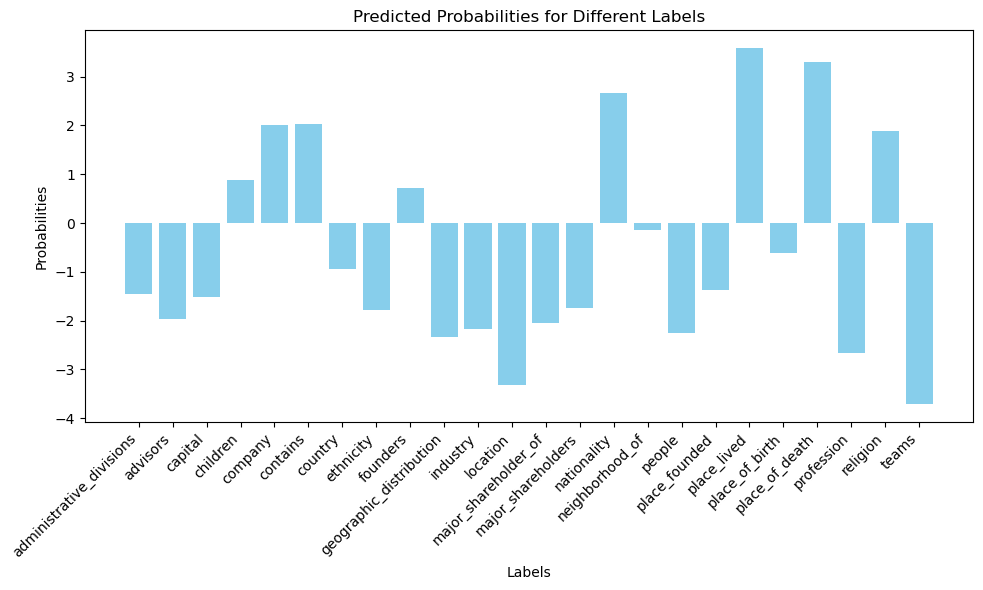

In [20]:
sentence_to_predict = "Alkhwarzmi was a muslim scientist"
predicted_probabilities, predicted_label = predict_all(
     model, tokenizer,sentence_to_predict)

print(f'predicted relation: {predicted_label}')


label_encoder_classes = label_encoder.classes_
predicted_probabilities = predicted_probabilities.squeeze().tolist()
plt.figure(figsize=(10, 6))
plt.bar(label_encoder_classes, predicted_probabilities, color='skyblue')

# Adding labels and title
plt.xlabel('Labels')
plt.ylabel('Probabilities')
plt.title('Predicted Probabilities for Different Labels')

# Rotating labels on the x-axis for better readability (optional)
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()

predicted relation: ['contains']


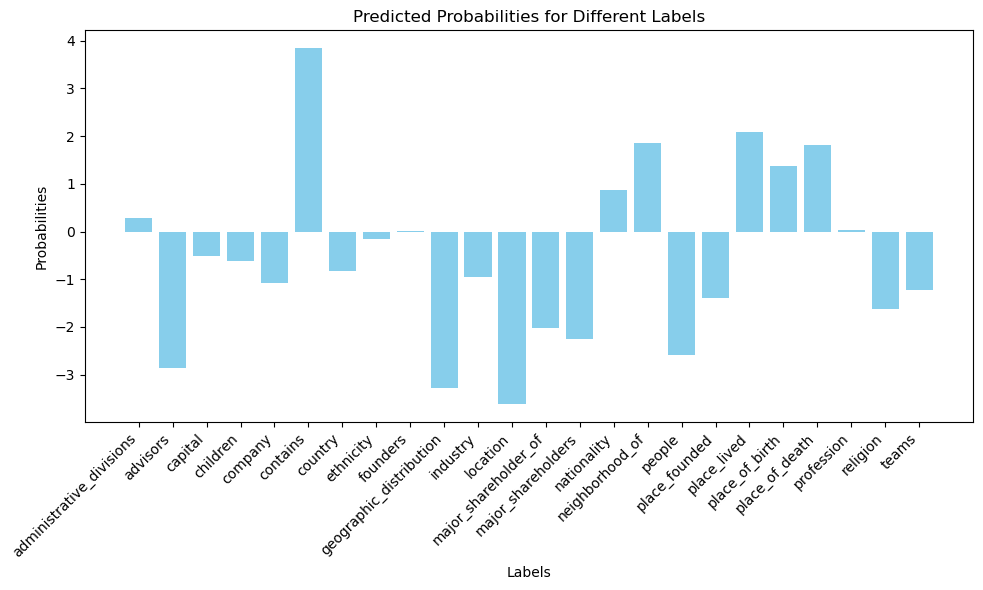

In [31]:
sentence_to_predict = "which organizations were founded in 1950?"
predicted_probabilities, predicted_label = predict_all(
     model, tokenizer,sentence_to_predict)

print(f'predicted relation: {predicted_label}')


label_encoder_classes = label_encoder.classes_
predicted_probabilities = predicted_probabilities.squeeze().tolist()
plt.figure(figsize=(10, 6))
plt.bar(label_encoder_classes, predicted_probabilities, color='skyblue')

# Adding labels and title
plt.xlabel('Labels')
plt.ylabel('Probabilities')
plt.title('Predicted Probabilities for Different Labels')

# Rotating labels on the x-axis for better readability (optional)
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()

predicted relation: ['contains']


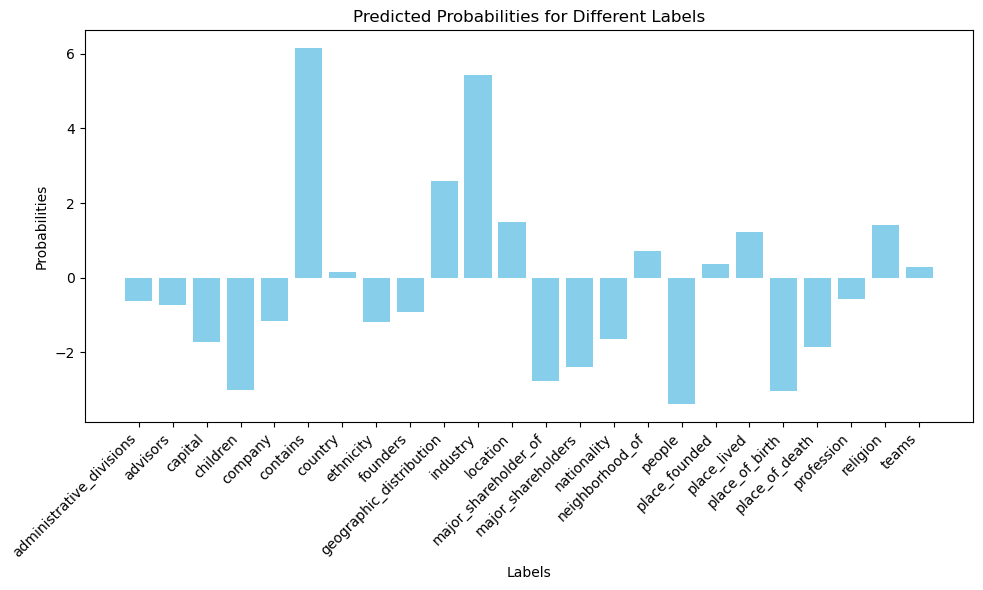

In [23]:
sentence_to_predict = "Now the United States Postal Service may be displaying a similar rebellious streak : tomorrow at the huge Sturgis motorcycle rally in the Black Hills of South Dakota , the Postal Service will issue a set of four stamps that depict classic American bikes ."
predicted_probabilities, predicted_label = predict_all(
     model, tokenizer,sentence_to_predict)

print(f'predicted relation: {predicted_label}')


label_encoder_classes = label_encoder.classes_
predicted_probabilities = predicted_probabilities.squeeze().tolist()
plt.figure(figsize=(10, 6))
plt.bar(label_encoder_classes, predicted_probabilities, color='skyblue')

# Adding labels and title
plt.xlabel('Labels')
plt.ylabel('Probabilities')
plt.title('Predicted Probabilities for Different Labels')

# Rotating labels on the x-axis for better readability (optional)
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()